[Social distancing detection tool](https://www.analyticsvidhya.com/blog/2020/05/social-distancing-detection-tool-deep-learning/)

The idea is to take a video with people walking on a street, detect people, measure distance between them and if the distance between two persons is less than a certain threshold draw red rectangles around each of them.

[Detectron2](https://github.com/facebookresearch/detectron2) is used to detect people on each frame. People are detected each frame separately, not tracking.

_Faster R-CNN_ is the model used for object detection.


**Runs only in [Google colab](https://colab.research.google.com/)**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Install dependencies

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# opencv is pre-installed on colab

!pip install torchvision
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!gcc --version

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [3]:
import torch
print('torch version:', torch.__version__)
print('Is cuda available?', torch.cuda.is_available())

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
from google.colab.patches import cv2_imshow
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

torch version: 1.5.0+cu101
Is cuda available? True


## Prepare video frames

In [0]:
!wget https://drive.google.com/u/0/uc\?id\=1N_nJRs7gStNrfB1G9y2yPs5voe4Ip4On\&export\=download -O sample.mp4
!rm -r frames/*
!mkdir -p frames/

In [5]:
%%time

def extract_frames(video_file, num_frames, output_folder) -> bool:
    cap = cv2.VideoCapture(video_file)

    if cap.isOpened() == False:
        return False

    frame_index = 0
    while cap.isOpened() and frame_index < num_frames:
        # read frame-by-frame
        ret, frame = cap.read()
        if ret:
            # save each frame
            cv2.imwrite(f'{output_folder}/{frame_index}.png', frame)
            frame_index += 1
        else:
            break

    print(f'Frame rate:', cap.get(cv2.CAP_PROP_FPS))

    return frame_index >= num_frames

video = 'sample.mp4'
num_frames = 100

print(f'Capturing {num_frames} frames')

res = extract_frames(video, num_frames, 'frames')
if res:
    print('Success')
else:
    print('Failed')

Capturing 100 frames
Frame rate: 25.0
Success
CPU times: user 8.85 s, sys: 249 ms, total: 9.1 s
Wall time: 8.62 s


## Test detectron predictor

In [0]:
def create_predictor():
    cfg = get_cfg()
    
    # add project-specific config (e.g., TensorMask) here if you're not 
    # running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))

    # set threshold for this model
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  

    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")

    return DefaultPredictor(cfg)


def detectron_imshow(img, predictor):
    outputs = predictor(img)
    cfg = predictor.cfg

    v = Visualizer(img[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.imshow(v.get_image()[:, :, ::-1])

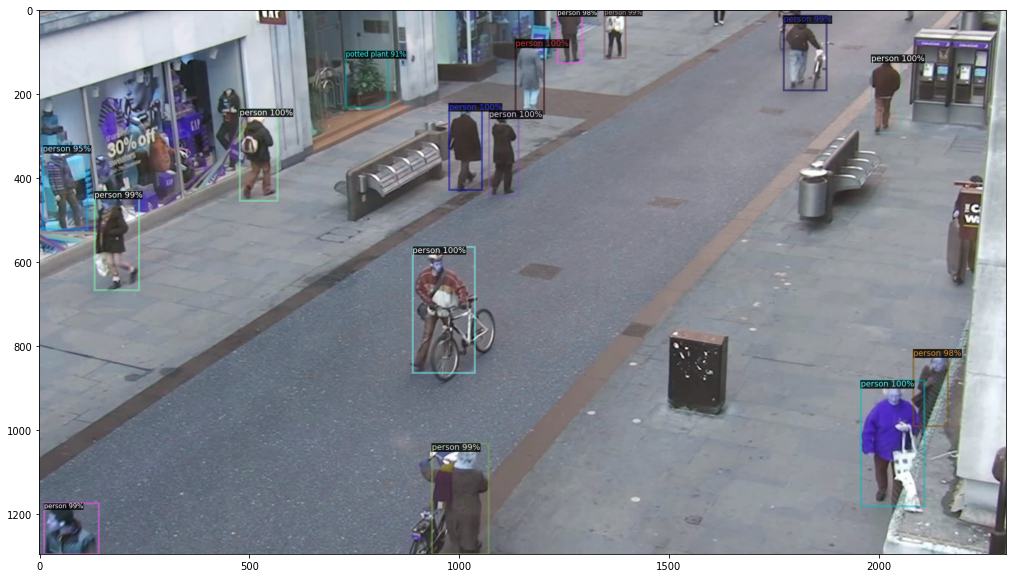

In [7]:
predictor = create_predictor()

plt.figure(figsize=(20, 10))
img = cv2.imread("frames/30.png")
detectron_imshow(img, predictor)

## Draw rectangle around detected persons

In [8]:
img = cv2.imread("frames/54.png")

pred = predictor(img)

# classes of detected objects
classes = pred['instances'].pred_classes.cpu().numpy()
print(classes)

# bounding boxes of detected objects
bbox = pred['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[ 0  0  0  0  0  0  0  0  0  0  1  1  0  0 24 58]
[[ 635.861      540.3057     756.9768     805.14484  ]
 [ 888.5975     155.60703    953.3177     314.93124  ]
 [ 962.6917     164.90044   1012.62115    329.9408   ]
 [ 847.58386    754.03284    981.6314    1020.47876  ]
 [ 476.8885     171.25676    555.89795    343.56027  ]
 [1655.6996      68.587204  1712.2284     220.22464  ]
 [1508.0302       0.        1584.2117     132.69345  ]
 [1076.7133       3.5929854 1124.1509     116.18794  ]
 [1652.532      777.25726   1753.6885    1029.943    ]
 [1001.0354      41.400925  1060.5459     190.0809   ]
 [1544.6443      40.761955  1602.911      131.94952  ]
 [ 663.5461     642.30817    799.7374     827.83453  ]
 [1788.8861     373.95972   1868.3833     610.0087   ]
 [   7.057088   269.79547     92.97852    436.8456   ]
 [ 482.80252    212.3326     523.345      261.8104   ]
 [ 606.0638      81.35293    692.9976     192.56554  ]]


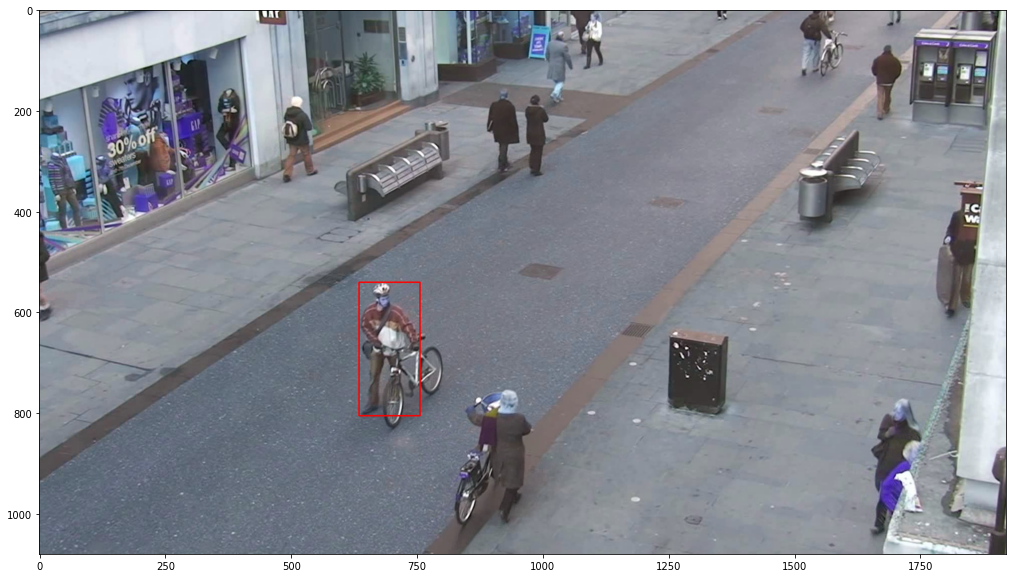

In [9]:
#identity only persons 
ind = np.where(classes == 0)[0]

#identify bounding box of only persons
person = bbox[ind]

#total no. of persons
num = len(person)

x1, y1, x2, y2 = person[0]

img = cv2.imread("frames/54.png")
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img);

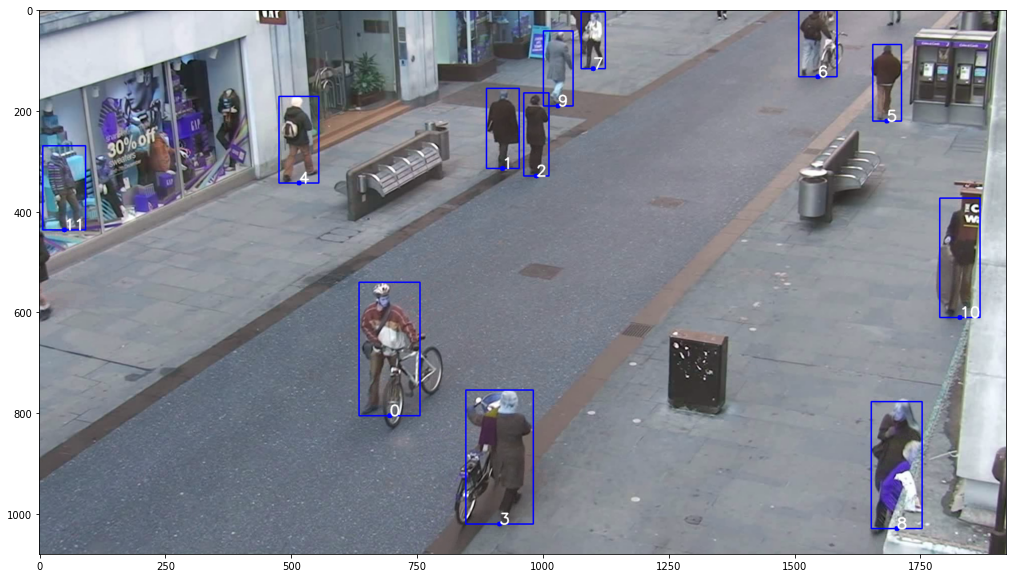

In [10]:
def mid_point(img, person, idx):
    """Function that returns the bottom center of every bbox"""

    # get the coordinates
    x1, y1, x2, y2 = person[idx]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # compute bottom center of bbox
    x_mid = int((x1 + x2) / 2)
    y_mid = int(y2)
    mid = (x_mid, y_mid)

    _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
    cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2, cv2.LINE_AA)

    return mid

midpoints = [mid_point(img, person, i) for i in range(len(person))]

plt.figure(figsize=(20,10))
plt.imshow(img);

## Measure distance between detected persons

In [0]:
from scipy.spatial import distance

def compute_distance(midpoints, num):
    dist = np.zeros((num, num))
    
    for i in range(num):
        for j in range(i+1, num):
            if i != j:
                dst = distance.euclidean(midpoints[i], midpoints[j])
                dist[i][j] = dst
    return dist

def find_closest(dist, num, thresh):
    p1 = []
    p2 = []
    d = []
    for i in range(num):
        for j in range(i, num):
            if((i != j) & (dist[i][j] <= thresh)):
                p1.append(i)
                p2.append(j)
                d.append(dist[i][j])
                
    return p1, p2, d

In [12]:
thresh = 100

dist = compute_distance(midpoints, num)

p1, p2, d = find_closest(dist, num, thresh)
df = pd.DataFrame({"p1": p1, "p2": p2, "dist": d})
df

,p1,p2,dist
0,1,2,68.659


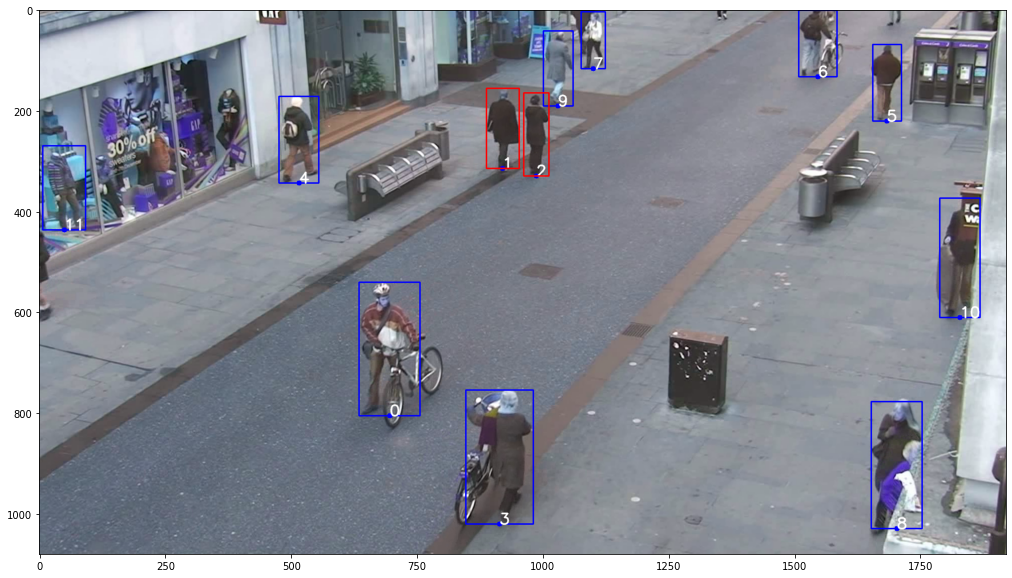

In [13]:
def change_2_red(img, person, p1, p2):
    risky = np.unique(p1 + p2)
    for i in risky:
        x1, y1, x2, y2 = person[i]
        _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img


img = change_2_red(img, person, p1, p2)

plt.figure(figsize=(20, 10))
plt.imshow(img);

## Create a new video and save to a file

In [0]:
def find_closest_people(predictor, frame, thresh):
    img = cv2.imread(f'frames/{frame}')

    pred = predictor(img)

    classes = pred['instances'].pred_classes.cpu().numpy()
    bbox = pred['instances'].pred_boxes.tensor.cpu().numpy()

    ind = np.where(classes == 0)[0]
    person = bbox[ind]

    midpoints = [mid_point(img, person, i) for i in range(len(person))]
    num = len(midpoints)
    
    dist = compute_distance(midpoints, num)
    p1, p2, d = find_closest(dist, num, thresh)
    
    img = change_2_red(img, person, p1, p2)
    cv2.imwrite(f'frames/{frame}', img)
    
    return 0

In [15]:
from tqdm import tqdm
import os
import re

files = os.listdir('frames/')
files.sort(key=lambda f: int(re.sub('\D', '', f)))

thresh = 100
predictor = create_predictor()

_ = [find_closest_people(predictor, files[i], thresh) for i in tqdm(range(len(files)))]

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [16]:
%%time

frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array = []

for i in range(len(frames)):

    # reading each files
    img = cv2.imread(f'frames/{frames[i]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width, height)

    # inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 25, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
    
out.release()

CPU times: user 5.59 s, sys: 200 ms, total: 5.79 s
Wall time: 5.64 s
